# **Informatyka w medycynie**

# Dno oka

*Grupa dwuosobowa: Ivan Kaliadzich 153936, Mikołaj Diakowski 151843*

## Dodawanie bibliotek

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, restoration
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import imageio as imageio
from PIL import Image
import matplotlib.patches as mpatches
from skimage import io
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Maсierz pomyłek

In [2]:

# Function to visualize and save the confusion matrix with a mask
def visualize_and_save_confusion_matrix_with_mask(expert_img, model_img, mask_img, filename, path_to_mask='mask/04_h_mask.tif'):
    tp = (expert_img == 1) & (model_img == 1)
    tn = (expert_img == 0) & (model_img == 0)
    fp = (expert_img == 0) & (model_img == 1)
    fn = (expert_img == 1) & (model_img == 0)
    
    vis_image = np.zeros((expert_img.shape[0], expert_img.shape[1], 3), dtype=np.uint8)
    vis_image[tp] = [0, 255, 0]  # Green for TP
    vis_image[tn] = [255, 255, 255]  # White for TN
    vis_image[fp] = [255, 0, 0]  # Red for FP
    vis_image[fn] = [0, 0, 255]  # Blue for FN
    
    # Apply mask to set pixels to white where mask is black
    vis_image[mask_img == 0] = [255, 255, 255]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(vis_image)
    plt.title('Macierz pomyłek')
    plt.legend(handles=[
        mpatches.Patch(color='red', label='FP'),
        mpatches.Patch(color='blue', label='FN'),
        mpatches.Patch(color='white', label='TN'),
        mpatches.Patch(color='green', label='TP')
    ], loc='upper right')
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)  # Save the figure to a file
    plt.show()


In [3]:
# Przykład funkcji do wczytywania i przetwarzania obrazów
def load_and_preprocess_images(image_paths):
    features = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))  # Zmiana rozmiaru obrazu
        plt.imshow(img)
        plt.show()
        img_features = img.flatten()  # Spłaszczenie obrazu do jednowymiarowej tablicy
        features.append(img_features)
    return np.array(features)


## Model drzewa decyzyjnego

In [6]:
from skimage.color import rgb2gray


def divide_image(image):
    feat_list = list()
    for i in range(len(image)):
        left_padding = 2
        right_padding = 2
        if i <= 2:
            left_padding = i
        if i >= len(image)-2:
            right_padding = len(image) - i 
        for j in range(len(image[0])):
            upper_padding = 2 
            lower_padding = 2
            if j <= 2:
                upper_padding = j
            if j >= len(image[0])-2:
                lower_padding = len(image[0]) - j

            frag = image[i-left_padding:i+right_padding, j-upper_padding:j+lower_padding, :]
            color_var_r = np.var(frag[:,:,2])
            color_var_g = np.var(frag[:,:,1])
            color_var_b = np.var(frag[:,:,0])
            frag[:,:,0] = 0
            frag[:,:,2] = 0
            frag = rgb2gray(frag)
            hu_moments = cv2.HuMoments(cv2.moments(frag)).flatten()
            hu_moments = np.append(hu_moments, color_var_r)
            hu_moments = np.append(hu_moments, color_var_g)
            hu_moments = np.append(hu_moments, color_var_b)
            feat_list.append(hu_moments)
            del frag

    return np.array(feat_list)

def mask_to_y(mask):
    mask = (mask > 0)*1
    return mask.flatten()


In [7]:
from skimage import util
def image_to_X(image, patch_size=5):
    pad_size = patch_size // 2
    padded = np.pad(image[:, :, 1], (pad_size, pad_size), mode='constant', constant_values=0)
    patches = util.view_as_windows(padded, window_shape=(patch_size, patch_size), step=1)
    return patches.reshape(-1, patch_size*patch_size)


In [11]:
patch_size = 11

In [12]:
from skimage import io

fundus = io.imread('images/04_h.jpg')
mask = io.imread('manual1/04_h.tif', 0)

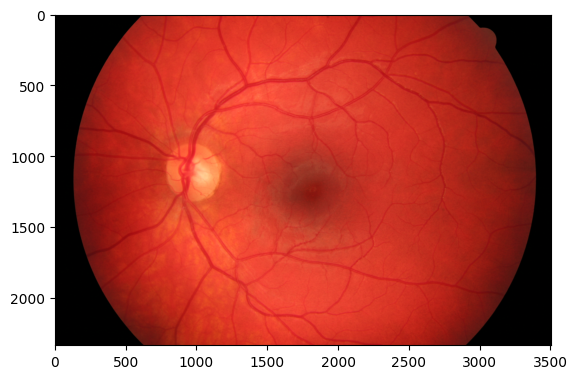

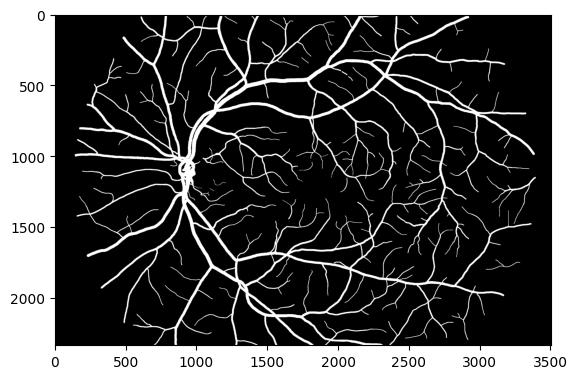

In [13]:
plt.imshow(fundus)
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()

In [138]:
y_train = mask_to_y(mask)

In [139]:
X_train = image_to_X(fundus, patch_size)

CPU times: user 526 ms, sys: 111 ms, total: 636 ms
Wall time: 636 ms


In [140]:
X_train.shape

(8185344, 121)

In [141]:
# np.savez("train_data", array1=X_train, array2=y_train)

In [142]:
# knn_model = KNeighborsClassifier(n_neighbors=3)
# knn_model.fit(X_train, y_train.flatten())

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [143]:
from imblearn.under_sampling import RandomUnderSampler

In [144]:
# Select a subsample - 5% of all examples + undersampling
n_train = X_train.shape[0]
sub = np.random.choice(n_train, int(0.05*n_train), replace=False)
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_train[sub], y_train[sub])

In [145]:
np.unique(y_under, return_counts=True)

(array([0, 1]), array([38723, 38723]))

In [146]:
model.fit(X_under, y_under)

CPU times: user 1min 23s, sys: 341 ms, total: 1min 24s
Wall time: 13.3 s


RandomForestClassifier(n_estimators=200, n_jobs=-1)

In [147]:
import pickle
with open('model-green.pkl', 'wb') as f:
    pickle.dump(model, f)

### Test 1 (02_h)

In [148]:
test_1 = io.imread('images/02_h.jpg')
X_test_1 = image_to_X(test_1, patch_size)

In [149]:
mask_1 = io.imread('manual1/02_h.tif', 0)
y_test_1 = mask_to_y(mask_1)

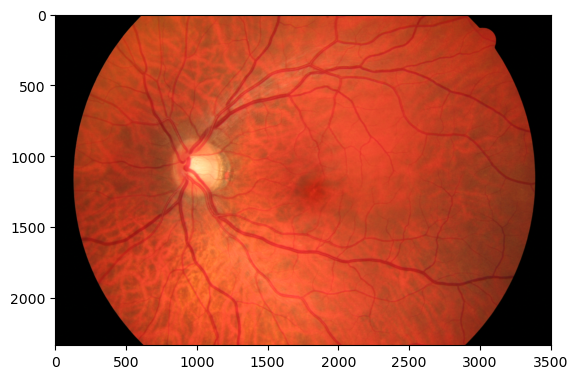

In [150]:
plt.imshow(test_1)

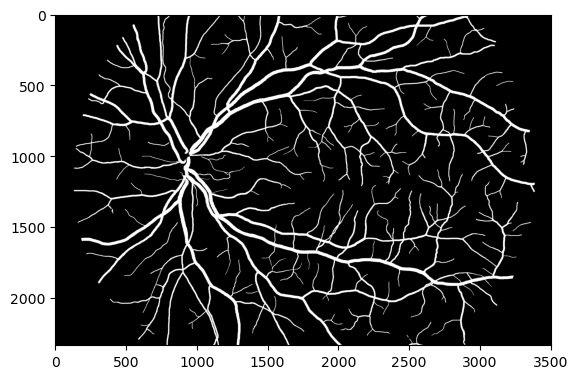

In [151]:
plt.imshow(mask_1, cmap='gray')

In [152]:
y_pred_1 = model.predict(X_test_1)

CPU times: user 3min 36s, sys: 1min 35s, total: 5min 11s
Wall time: 1min 9s


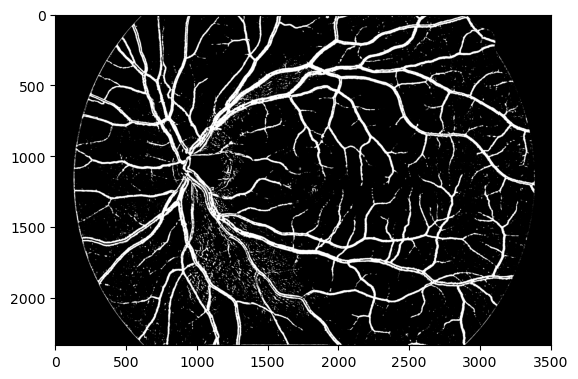

In [153]:
y_reshaped_1 = np.reshape(y_pred_1, mask_1.shape)
plt.imshow(y_reshaped_1, cmap='gray');

In [154]:
from sklearn.metrics import confusion_matrix

In [155]:
confusion_matrix(y_test_1, y_pred_1, normalize='true')

array([[0.95545138, 0.04454862],
       [0.1531311 , 0.8468689 ]])

### Test 2 (01_h)

In [156]:
test_2 = io.imread('images/01_h.jpg')
X_test_2 = image_to_X(test_2, patch_size)

CPU times: user 511 ms, sys: 86.3 ms, total: 597 ms
Wall time: 628 ms


In [157]:
mask_2 = io.imread('manual1/01_h.tif', 0)
y_test_2 = mask_to_y(mask_2)

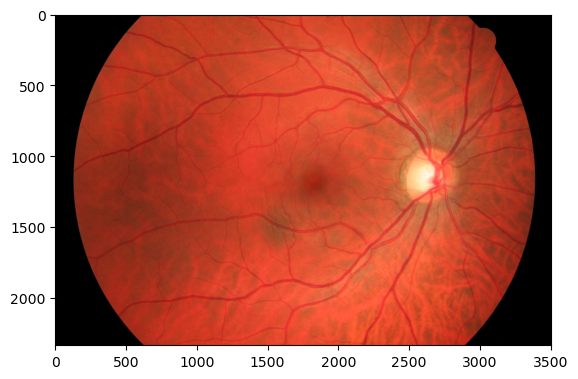

In [158]:
plt.imshow(test_2)

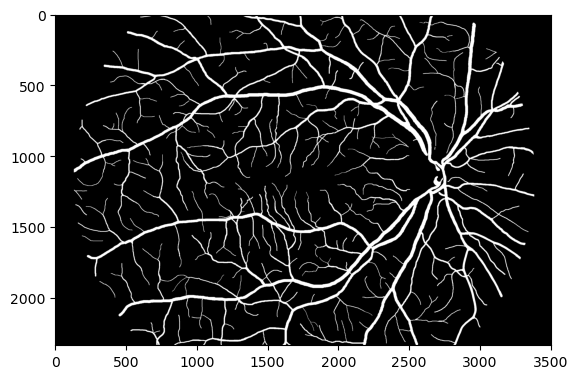

In [159]:
plt.imshow(mask_2, cmap='gray')

In [160]:
y_pred_2 = model.predict(X_test_2)

CPU times: user 3min 36s, sys: 1min 39s, total: 5min 16s
Wall time: 1min 10s


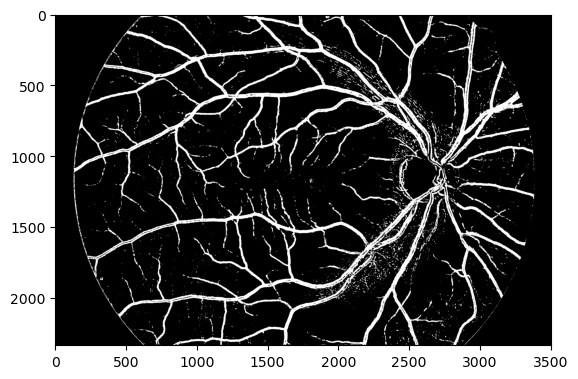

In [161]:
y_reshaped_2 = np.reshape(y_pred_2, mask_2.shape)
plt.imshow(y_reshaped_2, cmap='gray');

In [162]:
confusion_matrix(y_test_2, y_pred_2, normalize='true')

array([[0.95877443, 0.04122557],
       [0.22366073, 0.77633927]])

### Test 3 (06_g)

In [164]:
test_3 = io.imread('images/06_g.jpg')
%time X_test_3= image_to_X(test_3, patch_size)

CPU times: user 535 ms, sys: 80.8 ms, total: 616 ms
Wall time: 645 ms


In [165]:
mask_3 = io.imread('manual1/06_g.tif', 0)
y_test_3 = mask_to_y(mask_3)

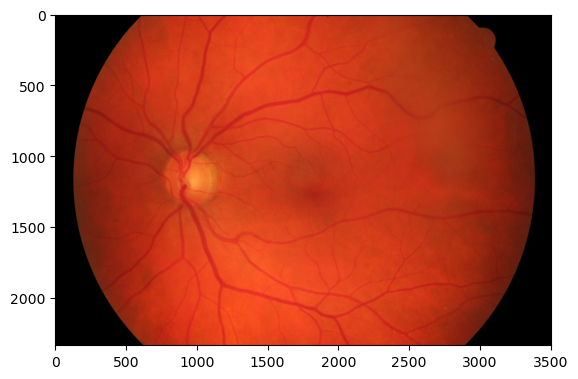

In [166]:
plt.imshow(test_3)

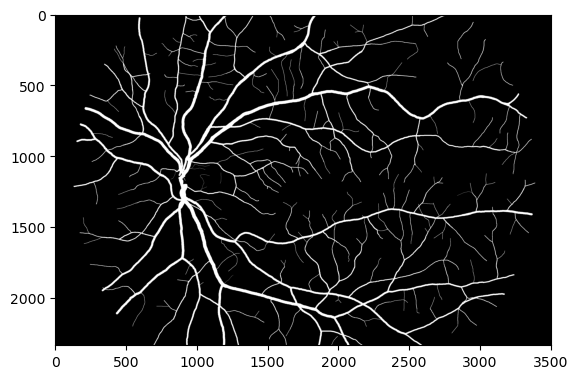

In [167]:
plt.imshow(mask_3, cmap="gray")

In [168]:
y_pred_3 = model.predict(X_test_3)

CPU times: user 4min 8s, sys: 1min 31s, total: 5min 39s
Wall time: 1min 9s


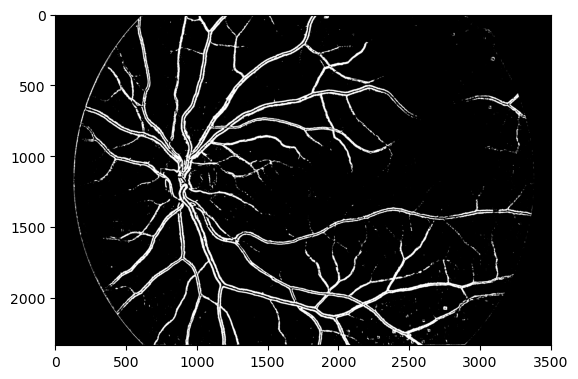

In [169]:
y_reshaped_3 = np.reshape(y_pred_3, mask_3.shape)
plt.imshow(y_reshaped_3, cmap='gray');

In [170]:
confusion_matrix(y_test_3, y_pred_3, normalize='true')

array([[0.96142286, 0.03857714],
       [0.41217297, 0.58782703]])